In [ ]:
!pip install tqdm

In [ ]:
import os
import openai
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import threading

openai.api_key = "--- Confidential ---"

In [2]:
class OpenAIRequestThread(threading.Thread):
    def __init__(self, content):
        self.response = None
        self.content = content
        threading.Thread.__init__(self)

    def run(self):
        try:
            self.response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[{"role": "user", "content": self.content}],
                temperature=0
            )
        except: {}
            

In [4]:
df_cc = pd.read_csv('counselchat-data.csv')
df_red = pd.read_csv('offmychest_dyadic.csv')

In [5]:
learning_power = len(df_cc.index) - 1200

In [6]:
prompt_eng_pre = """ 
What are overall all the emotions felt by the speakers that you detected in the text? One emotion should only be one word.
You need to output one list with all the emotions detected and what caused this emotion.
One text can contain multiple emotions.
The ouput strcture should be:
 { Emotion 1 / Cause 1, Emotion 2 / Cause 2, Emotion 3 / Cause 3, ...}
Do not froget the brackets ({})
The list should only contain emotions and causes strctured as described.
An emotion is: a strong feeling deriving from one's circumstances, mood, or relationships with others.
"""

In [7]:
results_history = []
for i in tqdm(range(0,learning_power)): 
    try:
        title_prompt = "The title of the text number " + str(i) + " is: "+str(df_cc.iloc[i]["questionTitle"])
        topic_prompt = "The topic of the text " + str(i) + " is: "+str(df_cc.iloc[i]["topics"])
        text_prompt = "The text is: \"\"\" "+str(df_cc.iloc[i]["questionText"]) +"\"\"\""
        prompt_request = prompt_eng_pre + "\n" + title_prompt + "\n" + topic_prompt + "\n" + text_prompt + "\n\n"
        
        request_thread = OpenAIRequestThread(prompt_request)
        
        request_thread.start()

        request_thread.join(timeout=10)
        
        if request_thread.is_alive():
            request_thread._stop() 
            results_history.append("Empty")
        else:
            response = request_thread.response
            results_history.append(response.choices[0].message.content)
            
    except:
        results_history.append("Empty")
    
print(results_history)

100%|██████████| 282/282 [10:32<00:00,  2.24s/it]

['{tense / Escalating disagreements between mother and wife}', '{Difficulty / Quitting smoking, Frustration / Addiction, Determination / Having a baby}', '{Anxiety / Keeping secrets from family}', '{Possessiveness / Insecurity}', '{Anxiety / Head injury and trouble sleeping}', '{Insecurity / Fear of being alone, Frustration / Unavailable partners, Helplessness / Emotional abuse, Determination / Desire for change}', '{Anger / Lack of control over anger}', "{Stress / Breakup, Fear / Nightmares, Stress / Father's business bankruptcy, Stress / Mother's chronic condition, Relief / Exercise and running, Fear / Nightmares}", '{Anger / Unethical therapy practices}', '{Frustration / Being called names by friends}', "{Betrayal / Husband's infidelity, Anger / Husband's infidelity, Fear / Lack of trust, Confusion / Unsure how to move forward, Concern / Children getting hurt}", '{Anxiety / Trouble sleeping, Irritability / Unspecified, Anxiety / Anxiety attacks}', "{Devastated / Husband seeing someo

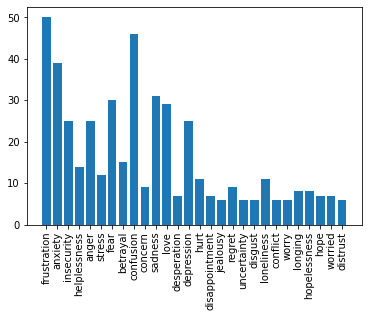

{'frustration': 50, 'anxiety': 39, 'insecurity': 25, 'helplessness': 14, 'anger': 25, 'stress': 12, 'fear': 30, 'betrayal': 15, 'confusion': 46, 'concern': 9, 'sadness': 31, 'love': 29, 'desperation': 7, 'depression': 25, 'hurt': 11, 'disappointment': 7, 'jealousy': 6, 'regret': 9, 'uncertainty': 6, 'disgust': 6, 'loneliness': 11, 'conflict': 6, 'worry': 6, 'longing': 8, 'hopelessness': 8, 'hope': 7, 'worried': 7, 'distrust': 6}


In [8]:
import matplotlib.pyplot as plt
from collections import Counter
import re

data = results_history

# Initialize an empty list to store the words
words = []

# Iterate through each item in the data list
for item in data:
    # Remove the curly braces and split the string into key-value pairs
    pairs = item.strip('{}').split(', ')
    # For each pair, split the pair into key and value and add the key to the words list
    for pair in pairs:
        word = pair.split(' / ')[0].lower()
        words.append(word)

# Count the frequencies of the words
word_freq = Counter(words)

# Filter out words with frequency equal to 1
word_freq = {key: val for key, val in word_freq.items() if val > 5}

# Create a bar chart
plt.bar(word_freq.keys(), word_freq.values())
plt.xticks(rotation='vertical')
plt.show()

print(word_freq)


In [11]:
prompt_eng_pre = """ 
You will be given emotions and what caused these emotions is this format:
Emotion / Cause of this emotion
"""
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": prompt_eng_pre + str(results_history[:100])}],
    temperature=0
)

print(response.choices[0].message.content)

As an AI language model, I can provide a summary of the emotions and causes provided in the format given. The emotions and causes include:

- Tense / Escalating disagreements between mother and wife
- Difficulty / Quitting smoking, Frustration / Addiction, Determination / Having a baby
- Anxiety / Keeping secrets from family
- Possessiveness / Insecurity
- Anxiety / Head injury and trouble sleeping
- Insecurity / Fear of being alone, Frustration / Unavailable partners, Helplessness / Emotional abuse, Determination / Desire for change
- Anger / Lack of control over anger
- Stress / Breakup, Fear / Nightmares, Stress / Father's business bankruptcy, Stress / Mother's chronic condition, Relief / Exercise and running, Fear / Nightmares
- Anger / Unethical therapy practices
- Frustration / Being called names by friends
- Betrayal / Husband's infidelity, Anger / Husband's infidelity, Fear / Lack of trust, Confusion / Unsure how to move forward, Concern / Children getting hurt
- Anxiety / Trou

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

sentences = [
"Escalating disagreements between mother and wife",
"Quitting smoking",
"Addiction",
"Having a baby",
"Keeping secrets from family",
"Insecurity",
"Head injury and trouble sleeping",
"Fear of being alone",
"Unavailable partners",
"Emotional abuse",
"Desire for change",
"Lack of control over anger",
"Breakup",
"Nightmares",
"Father's business bankruptcy",
"Mother's chronic condition",
"Exercise and running",
"Nightmares",
"Unethical therapy practices",
"Being called names by friends",
"Husband's infidelity",
"Husband's infidelity",
"Lack of trust",
"Unsure how to move forward",
"Children getting hurt",
"Trouble sleeping",
"Unspecified",
"Anxiety attacks",
"Husband seeing someone else",
"Husband's infidelity",
"Husband's doubts about her intentions",
"Wanting to work things out",
"Being hurt by a man",
"Letting go of the man",
"Threat of losing pets",
"Breakup",
"Mixed signals",
"Desire to reconcile",
"Fear of losing family and relationship",
"Enduring sexual and physical abuse by brother",
"Enduring sexual and physical abuse by brother",
"Family Conflict",
"Family Conflict",
"Social Relationships",
"Family Conflict",
"Cheating",
"Lack of Affection",
"Unfair Expectations",
"Desire for Help",
"Violent thoughts and dreams",
"Separation from girlfriend",
"Inability to reach husband for help",
"Inability to access base without ID",
"Need to continue seeing doctor",
"Being ignored after miscarriage",
"Not getting a job",
"Finding out about the other woman",
"Being closed in the car window and thrown out of the car",
"11 year abusive marriage",
"Left for another woman",
"Mentally and emotionally abused",
"Working as a server",
"Cruelty of ex-partner",
"No contact from people who cared",
"Brother refusing to lend money",
"Losing faith in humanity",
"Infidelity",
"Hurt, Communication Issues",
"Proposal",
"Other people's weddings",
"Other people's proposals and weddings",
"Not getting the desired proposal and wedding",
"Inability to move on",
"Grief and Loss",
"Police not believing",
"Inability to reach a therapist",
"Request for advice",
"Sudden divorce",
"Divorce",
"Fighting for family",
"Boyfriend passing away",
"Boyfriend passing away",
"Inability to find happiness after boyfriend's passing",
"Past actions",
"Choosing between two guys",
"Current relationship",
"Second guy",
"How to tell first guy",
"Speaker's promiscuous past",
"Fear of Rejection",
"Lack of Acceptance",
"Desire for Love",
"Concern for daughter's safety",
"Frustration towards step child's behavior",
"Opening up about fetish",
"False statements",
"Illness and Emotional Distress",
"Lack of acknowledgement from parents",
"Lack of acknowledgement from father",
"Shut down opinions",
"Past incident",
"Lack of acknowledgement from father",
"Boyfriend's mother",
"Erection problems",
"Husband's cheating",
"Moving on",
"Abuse in relationships",
"Gender identity",
"Gender identity",
"Self-discovery",
"Peer influence",
"Difficulty getting over it",
"Past experience",
"Current situation",
"Cousin's condescending comments",
"Cousin's criticism of the speaker's character",
"Cousin's short-fused and highly temperamental behavior",
"Emotional abuse",
"Mixed signals",
"Belittlement",
"Lack of support",
"Father's drinking problem",
"Different views on religion",
"Feeling worthless and having no interest in anything",
"Past events and current mental status",
"Feeling like time is going too fast",
"Abandonment",
"Fear of rejection",
"Lack of closure",
"Uncertainty about how to approach the situation",
"Domestic Violence",
"Discrediting",
"Feeling Unhappy",
"Falling in love with a sex offender",
"Family doesn't accept him",
"Appearance",
"Appearance",
"Bullying",
"Self-worth",
"Lack of Support",
"Low self-esteem",
"Positive feedback",
"Unrequited love",
"Distance and unattainability",
"Lying to mom and losing her trust",
"Lack of attraction to husband",
"Attraction to other men",
"Lack of intimacy",
"Feeling of being ganged up on",
"Doubt about own feelings",
"Feeling of being mistreated",
"Feeling towards self",
"Perception of friends' behavior",
"Perception of friends' behavior",
"Postpartum",
"Past affair",
"Wife and family",
"Losing wife and family",
"Heartbreak",
"Relationship communication issues",
"Diminished libido",
"Lack of intimacy",
"Fake orgasm",
"Denial",
"Losing mother",
"Family Conflict",
"Self-esteem",
"Fear of judgement or rejection",
"Uncertainty about career",
"Difficulty coping with challenges",
"Approaching girls",
"Frequent fighting",
"Wanting to save family",
"Ex-boyfriend",
"Ex-boyfriend",
"Feeling not good enough",
"Trauma from rape",
"Promiscuity as coping mechanism",
"Cheating",
"Cheating",
"Cheating",
"Cheating",
"Husband's infidelity",
"Husband's infidelity",
"Lack of trust",
"Unsure how to move forward",
"Children's well-being",
"Letting little things bother me",
"Being the mom my kids deserve",
"Lack of priority in the relationship",
"Lack of priority in the relationship",
"Fear of being alone and not finding someone else",
"Fear of being alone and not finding someone else",
"Boyfriend going out with female friend without introducing me",
"Fear of Rejection",
"Lack of Acceptance",
"Need for Love",
"Unsatisfying sexual relationship",
"Feeling unreciprocated in relationship",
"Ex's comment about never finding anyone else",
"Social situations",
"Living with bipolar mother",
"No friends or family",
"No money for therapy",
"Overeating",
"Negative tone of voice",
"Unclear Communication",
"Lack of Trust",
"Inability to Understand",
"Fear of Losing Sanity"]


# Convert sentences to TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(sentences)

# Perform KMeans clustering
true_k = 10  # Set the number of clusters you want to group your sentences into
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

# Print clustering results
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:  # Print top 10 words per cluster
        print(f' {terms[ind]}')
    print()

print("Prediction")
Y = vectorizer.transform(["new sentence"])  # Use a new sentence to test the model
prediction = model.predict(Y)
print(prediction)

Cluster 0:
 acknowledgement
 lack
 father
 parents
 fake
 ex
 exercise
 expectations
 experience
 faith

Cluster 1:
 lack
 family
 boyfriend
 past
 conflict
 inability
 trust
 mother
 abuse
 desire

Cluster 2:
 husband
 infidelity
 seeing
 attraction
 doubts
 intentions
 help
 reach
 inability
 lack

Cluster 3:
 fear
 rejection
 losing
 sanity
 judgement
 relationship
 family
 expectations
 escalating
 esteem

Cluster 4:
 finding
 woman
 fear
 left
 comment
 ex
 year
 experience
 events
 exercise

Cluster 5:
 self
 esteem
 worth
 discovery
 feeling
 low
 year
 experience
 ex
 exercise

Cluster 6:
 cheating
 husband
 year
 fake
 events
 ex
 exercise
 expectations
 experience
 faith

Cluster 7:
 hurt
 communication
 issues
 unclear
 man
 children
 getting
 relationship
 expectations
 events

Cluster 8:
 feeling
 ganged
 unhappy
 mistreated
 good
 unreciprocated
 worthless
 having
 relationship
 like

Cluster 9:
 unfair
 expectations
 year
 feelings
 events
 ex
 exercise
 experience
 fait